Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
3/3 [==============================] - 0s 22ms/step - loss: 207.1642
Epoch 2/1000
3/3 [==============================] - 0s 2ms/step - loss: 206.2239
Epoch 3/1000
3/3 [==============================] - 0s 2ms/step - loss: 205.2659
Epoch 4/1000
3/3 [==============================] - 0s 2ms/step - loss: 204

3/3 [==============================] - 0s 4ms/step - loss: 55.1705
Epoch 92/1000
3/3 [==============================] - 0s 2ms/step - loss: 55.2691
Epoch 93/1000
3/3 [==============================] - 0s 4ms/step - loss: 55.3097
Epoch 94/1000
3/3 [==============================] - 0s 2ms/step - loss: 55.3399
Epoch 95/1000
3/3 [==============================] - 0s 3ms/step - loss: 55.2835
Epoch 96/1000
3/3 [==============================] - 0s 4ms/step - loss: 55.2045
Epoch 97/1000
3/3 [==============================] - 0s 4ms/step - loss: 55.1622
Epoch 98/1000
3/3 [==============================] - 0s 4ms/step - loss: 55.0386
Epoch 99/1000
3/3 [==============================] - 0s 3ms/step - loss: 54.8848
Epoch 100/1000
3/3 [==============================] - 0s 2ms/step - loss: 54.8619
Epoch 101/1000
3/3 [==============================] - 0s 4ms/step - loss: 54.8881
Epoch 102/1000
3/3 [==============================] - 0s 1ms/step - loss: 54.8479
Epoch 103/1000
3/3 [===================

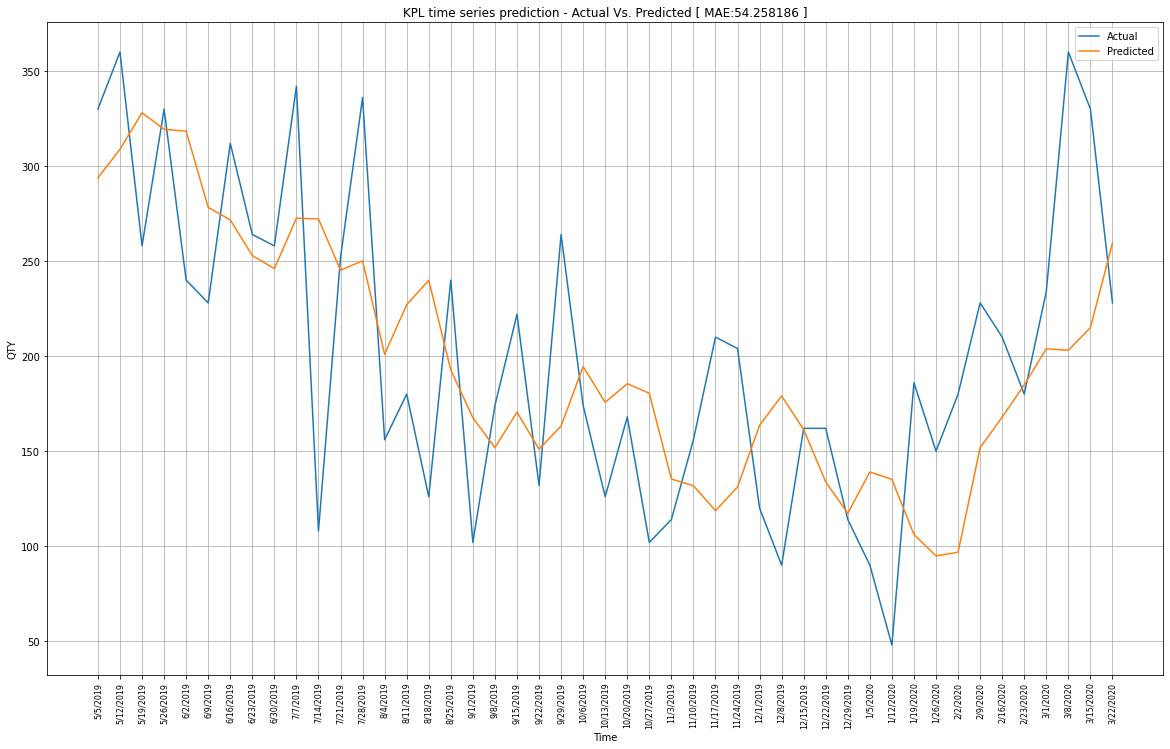

In [38]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(20, 8))
    plt.xticks(rotation=90, size=8)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()
time_step = []
qty = []
with open('Mean_WEEK-WISE_FGAS-660A-16-00087B4covid.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i in reader:
    qty.append(int(i[1]))
    time_step.append((i[0]))
series = np.array(qty)
time = np.array(time_step)
# plot_series(time, series)
# split_time = int(1 * len(series))
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]
time_train = time
x_train = series
window_size = 4
batch_size = 21
shuffle_buffer_size = 55
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# relu | LeakyReLU | gelu | elu | selu | swish
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=[window_size], activation="LeakyReLU"),
    tf.keras.layers.Dense(4, activation="LeakyReLU"),
    tf.keras.layers.Dense(1, activation="LeakyReLU")
])
print(model.summary())
# opt adam | adagrad | Adadelta | RMSprop | SGD | momntum | NAG |
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.compile(loss="mae", optimizer='adam')
model.fit(dataset, epochs=1000, callbacks=[callback], verbose=1)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# # patience: Number of epochs with no improvement after which training will be stopped.
# # # LR
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
# plt.semilogx(history.history["lr"], history.history["loss"])
# # plt.axis([1e-8, 1e-4, 0, 800])
# plt.show()
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
# forecast = forecast[:]
results = np.array(forecast)[:,0,0]
# results = np.roll(results, +5)
# results = results[:]
# print('forecast:\n', forecast)
# print('results:\n', results)
time_train = time_train[4:]
x_train = x_train[4:]
MAE = tf.keras.metrics.mean_absolute_error(x_train, results).numpy()
print('MAE: ', MAE)
plt.figure(figsize=(20, 12))
plt.plot(time_train, x_train, label='Actual')
plt.plot(time_train,results, label='Predicted')
plt.title('KPL time series prediction - Actual Vs. Predicted [ MAE:'+str(MAE)+" ]")
plt.xlabel("Time")
plt.ylabel("QTY")
plt.xticks(rotation=90, size=8)
plt.legend(loc='upper right')
plt.grid(True)
# plt.savefig('adagrad LeakyReLU b 45 img.jpg')
plt.show()

In [29]:
# forecast for next 10 days
n_features = 4
# results = results
results = results.astype(int)
print(results)
print(len(results))
# demonstrate prediction for next 10 days
x_input = np.array(results)[42:]
temp_input = list(x_input)
lst_output = []
i = 0
while i < 4:
    if len(temp_input) > 4:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_features))
#         x_input = x_input.flatten()
        # forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
        yhat = model.predict(x_input)
        print("{} day output {}".format(i, yhat))
        temp_input.append(yhat[0][0])
        temp_input = temp_input[1:]
        lst_output.append(yhat[0][0])
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i = i + 1

print(lst_output)
result = pd.DataFrame(lst_output)
# result.to_csv('RMSprop LeakyReLU output for next 4 weeks.csv')

# Visualizing The Output
# # pred = np.arange(771, 776)
# F = np.arange(776, 781)
# # print(pred)

# results = results[0:]
# print(results)
# lst_output = np.array(lst_output)
# lst_output = lst_output.astype(int)
# print(F)
# print(lst_output)

# # plt.plot(pred, results)
# plt.plot(F, lst_output)
# lst_output = pd.DataFrame(lst_output)
# lst_output.to_csv('prednew.csv')
# plt.show()

[290 317 322 315 287 287 244 247 264 257 269 254 194 243 232 195 174 159
 175 145 172 169 178 207 170 151 140 114 121 145 176 172 130 118 136 136
 116  88  91 132 144 176 194 194 192 235 289]
47
0 day input [194 192 235 289]
0 day output [[221.77701]]
1 day input [192.         235.         289.         221.77700806]
1 day output [[239.1055]]
2 day input [235.         289.         221.77700806 239.10549927]
2 day output [[229.4926]]
3 day input [289.         221.77700806 239.10549927 229.49259949]
3 day output [[228.53625]]
[221.77701, 239.1055, 229.4926, 228.53625]


In [34]:
time_train = pd.DataFrame(time_train, columns=['DATE'])
print('time_train:\n', time_train.tail())
print('len^:', len(time_train))


time_train:
          DATE
42  2/23/2020
43   3/1/2020
44   3/8/2020
45  3/15/2020
46  3/22/2020
len^: 47


In [36]:
time_train.loc[time_train.index[-1], 'DATE']

'3/22/2020'

In [30]:
future_dates = pd.date_range(start = '03-10-2020', end = '03-31-2020', freq = 'W-TUE')
future_dates

DatetimeIndex(['2020-03-10', '2020-03-17', '2020-03-24', '2020-03-31'], dtype='datetime64[ns]', freq='W-TUE')

In [31]:
future_dates = pd.date_range(start = time_train[-1], periods = 4, freq = 'W-TUE')
future_dates

TypeError: Expected unicode, got numpy.str_

In [ ]:
# [202.29839, 219.3256, 214.9485, 224.9757]